# Welcome

This notebook explores the **application of Stable Diffusion to food**, and it harnesses teachings from [FastAI's Course](https://course.fast.ai). 

In this notebook, we will do the following:
1. Build a Stable Diffusion model that takes in a prompt as input, and returns an image.
2. Give the model the ability to turn one image into another. (i.e a mango cheesecake into mango tiramisu). What I call "Dish2Dish".
3. Peek under the hood of training/executing a Stable Diffusion model while making intuitive connections.
4. See the baked-in creativity, in three places:
    * Initial Random Noise (i.e starting from a 'blank slate')
    * Classifier-Free Guidance (i.e learning the essence without relying too much on explicit guidance)
    * Sampling from Latent Distribution (i.e variability in the generation process)

I wrote this notebook as an experimental wing to [MangoCrisp](https://mangocrisp.com), an app I am building that acts as a culinary 'genie in a bottle', giving you the ability to create unique dishes. Currently, the app uses DALL-E 3 to generate images, but I'd like to build and deploy my own image generation models that are hopefully as good as DALL-E.

*This is an extension of the Stable Diffusion notebooks in the repository [here](https://github.com/fastai/diffusion-nbs). Some of the code blocks are taken from those notebooks for common functionality and convenience.*

# Getting started

Below, we will install the necessary dependencies. We will be using a [Stable Diffusion model from HuggingFace](https://huggingface.co/CompVis/stable-diffusion-v1-4), for which you will need to log in, and also accept the terms of the licence for this model.

In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires transformers>=4.33.1, but you have transformers 4.25.1 which is incompatible.


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Loading the models

This code comes from the [HuggingFace example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). Below, we load the relevant models. We will be diving deeper shortly.

In [3]:
# The model to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# The models to tokenize and and encode the text, respectively
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The model to generate the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler for adding noise in a systematic fashion
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move models to the GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Stable Diffusion in a loop

What you are about to see is Stable Diffusion, in a loop, in plain code. The code for this is adapted from the [HF notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) and looks very similar to what you'll find if you inspect [the `__call__()` method of the stable diffusion pipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200). But before we see this, let's first lay the framework for smooth-sailing. Specifically, let's set up some helper functions:

### Prepare the scheduler

In the function below, we prepare scheduler to manage the steps of the diffusion process. The process of creating an image from plain text is systematic, and accordingly, requires a 'schedule' of sorts. 

We will see more about this shortly. But in short, the model must be essentially be trained to carve out an image from noise, and doing this in not (at least in 2024) a one step thing. In other words, there are simply too many ways to go astray when attempting to carve out an image from noise in one single step. As such, there must be guidance along the way.

In [4]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

### Latents -> image tensor

Below, we define a function that takes a latent and Varational AutoEncoder (VAE) as an input. A latent is a condensed representation of an image.

The VAE is used to "decode" the latent back into a distribution of possible images, and then we take a random sample from this distribution, giving us a single image tensor. This act of randomly sampling from a distribution is one way to add a **sprinkle of creativity** into the model.

In [5]:
def latents_to_image(latents):    
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    return image

### Image tensor -> Pillow image

Below, we define a function that takes an image tensor as input, and returns a [Pillow](https://python-pillow.org/)-compatible image to display. Pillow is a module that allows us to work with images more easily, like opening, manipulating, displaying, analyzing, and saving many different image file formats. It should already be installed in your notebook if you are using something like [Kaggle](https://www.kaggle.com/). You can check like this:

In [6]:
!pip show pillow

Name: Pillow
Version: 9.5.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Jeffrey A. Clark (Alex)
Author-email: aclark@aclark.net
License: HPND
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: bokeh, contextily, datashader, diffusers, easyocr, fastai, fury, ImageHash, imageio, imgaug, ipyvolume, matplotlib, openslide-python, pdf2image, pyocr, pytesseract, scikit-image, torchvision, vaex-viz, wordcloud


But back to the function:

In [7]:
def get_pil_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

The function above is utility to convert images from a PyTorch tensor format, as they come out of a neural network, into a format that can be easily manipulated and saved using Pillow.

### Prompt -> Text embeddings

Below, we define a function that takes a prompt and creates text embeddings from it. Put simply, text embeddings (a vector of numbers) are what the model needs to understand the words and their intermingled relationships with other words.

You will also notice below, that we create *two* sets of embeddings; one is derived from the prompt (i.e "a mango cheesecake"), and the other is derived from empty text.

Here lies in our second sprinkle of creativity, what they call "classifier-free guidance". We will dive deeper into this later in this notebook.

In [8]:
def prepare_text_embeddings(prompt: str, batch_size):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    return torch.cat([uncond_embeddings, text_embeddings])

### Finally, the Stable Diffusion
Below, you can see that Stable Diffusion is just a conjunction of our helper functions, the models (i.e `vae`, `unet`), and a loop.

In [9]:
def stable_diffusion(
    prompt, height=512, width=512, 
    num_inference_steps=50, guidance_scale=7.5, 
    custom_latents=None,
    loop_start_step=0,
    generator_seed=32, batch_size=1, 
):
    
    text_embeddings = prepare_text_embeddings(prompt, batch_size)
    set_timesteps(scheduler,num_inference_steps)
    
    if (custom_latents is not None):
        latents = custom_latents
    else:
        latents = torch.randn(
          (batch_size, unet.config.in_channels, height // 8, width // 8),
          generator=torch.manual_seed(generator_seed),
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma
    
    with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            if i < loop_start_step:
                continue
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]

            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    imageTensor = latents_to_image(latents)
    return get_pil_image(imageTensor)

### Notes about the diffusion loop above

The function above takes a prompt (+ other parameters) as input, and returns an image. We will cover what really is happening in this function, shortly.

#### Preparing the latents

One thing you will notice is that we **prepare the latents** before we begin the loop.

*Recall: our stable diffusion needs some random noise latents to start with, and it will systematically remove this noise, producing de-noised latents. And these de-noised latents are what we feed to the decoder wing of VAE (via `latents_to_image` to get our final image.*

Below, we prepare the latents by randomly generating a tensor of size `(1, 4, 64, 64)` (batch size, channels, height, width).

Why do we divide the height and width by 8? 

This typically determined by the number of downsampling steps in the encoder. For instance, if there are three downsampling layers each reducing the dimensions by a factor of 2, the overall reduction would be `2^3 = 8`. Thus, an input image of size height x width would be reduced to a size of (height / 8) x (width / 8) in the latent space.

#### Performing (classifier-free) guidance

These two lines are quite telling:

```
noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
```

What's going on here?

During the sampling/inference process, the model generates an image based on noise (randomness). It uses both the prompt-specific embeddings and the classifier-free embeddings to guide this process. The key aspect of classifier-free guidance is balancing the influence of the prompt-specific embeddings and the classifier-free embeddings. By biasing slightly towards the text embeddings, the model is guided to generate an image relevant to the prompt. 

However, by not over-relying on these embeddings, the model retains a degree of **freedom and creativity**. This freedom allows it to use its "internal understanding" of images and reality, leading to creative and sometimes more natural or coherent image generation. It helps in avoiding overly literal interpretations of the text and encourages a more nuanced and context-aware image generation.**We don't want to be overly prescriptive.**

Recall, that during training, we systematically add noise to images, have the model predict the noise, keep going until we get something of pure noise. During this training, the model has learned to understand what is an image, that is, a "pure" image, without noise, and one that depicts something of reality, and what is not. With these above two lines of code, we are allowing the model to refine the noise into an image that has a **base foundation of reality**. That foundation of reality must be there, on top of which we can "mould" it into a specific representation of something like ice cream. 

The model then refines this general image towards the specifics of the given prompt (i.e cheesecake). This step is where the text embeddings specific to the prompt guide the image generation process to match the desired outcome.

**In summary:** The model first establishes a base that is grounded in what it has learned about images in general, and then it adds details specific to the prompt to create the final image. This method allows for a balance between realistic image generation and adherence to the specifics of the given prompt.

### Insanely simple interface
Our function to perform the Stable Diffusion has an insanely simple interface:
* Input: Prompt
* Output: Image

This is all we want.

  0%|          | 0/50 [00:00<?, ?it/s]

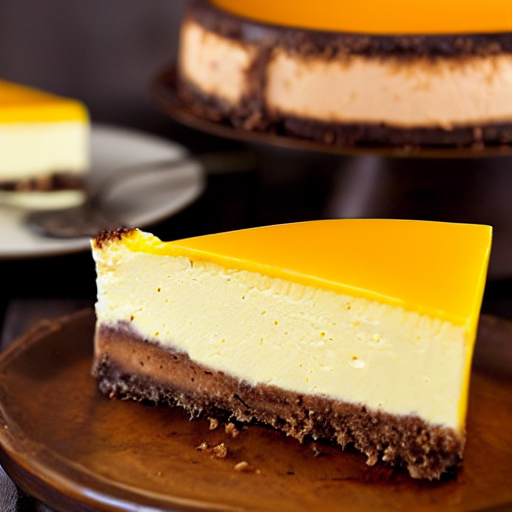

In [10]:
# Insanly simple interface: Prompt -> Image
mango_cheesecake = stable_diffusion("A mango cheesecake")
mango_cheesecake

In [11]:
mango_cheesecake.save('mango_cheesecake.png')

Now that  we can see what's happening from a birds-eye view, it's time to get deeper.

## The Autoencoder (AE)

The AE can compress (or 'encode') an image into a 'latent representation', and "decode" this back into an image. Below, I've put together two functions that encode and decode, respectively. Note that both functions need use the`vae` model that we loaded at the beginning of this notebook.

In [14]:
def pil_to_latent(input_im):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1)
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    image = latents_to_image(latents)
    return get_pil_image(image)

### About pil_to_latent:

1. `unsqueeze(0)` is used to add an additional dimension to the tensor, essentially converting it from a shape like [channels, height, width] to [batch size, channels, height, width].
This is done because PyTorch models typically expect batched input, even if you're only processing a single image. The extra dimension represents the batch size, which in this case is 1.

2. The operation `*2-1` is a common scaling technique used in neural network preprocessing. It transforms the range of the pixel values from [0, 1] to [-1, 1].
This scaling often helps with the performance of neural networks as it centers the data around zero and can lead to faster convergence during training.

3. `latent.latent_dist.sample()` generates a sample from the latent distribution learned by the VAE. 

Now, let's encode and decode an image to refine our understanding.

### Encoding

Let's first encode our `mango_cheesecake` image into its latent representation.

In [17]:
mango_cheesecake_latent = pil_to_latent(mango_cheesecake)
mango_cheesecake_latent.shape # (batch size, channels, height, width)

torch.Size([1, 4, 64, 64])

And, let's visualize the four channels of this latent representation.

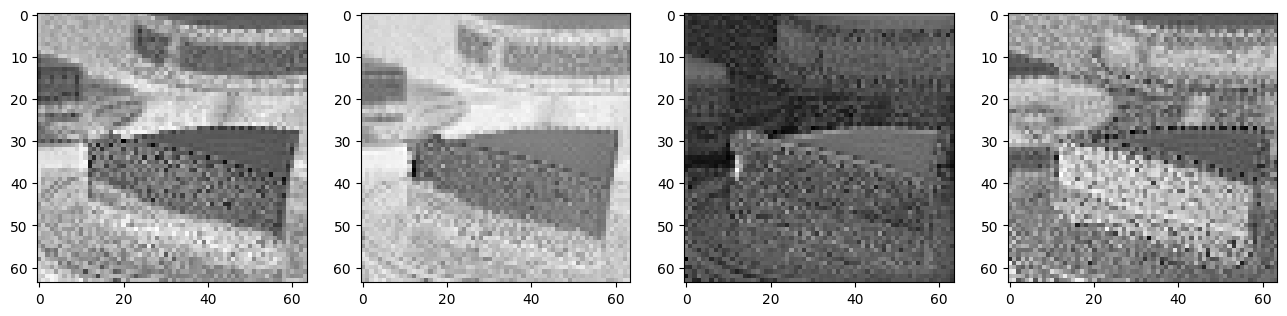

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(mango_cheesecake_latent[0][c].cpu(), cmap='Greys')

It's now time to decode this back into its original form.

### Decoding

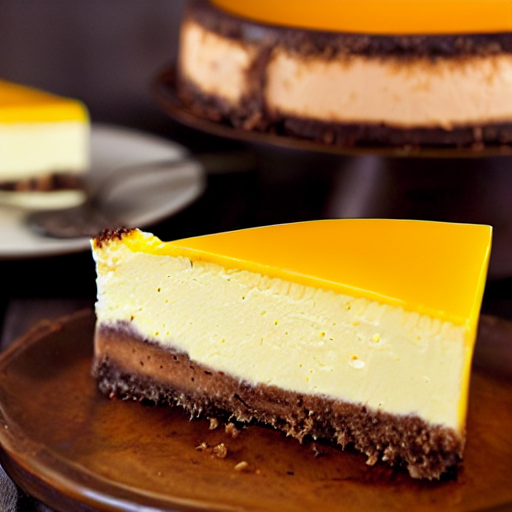

In [101]:
mango_cheesecake_copy = latents_to_pil(mango_cheesecake_latent)
mango_cheesecake_copy

### What just happend?

As you can see, the AE has retained virtually all of the original image. 

This AE has been trained to compress an image (while retaining much of the image's "truth") and then re-create the image back from this compressed version.

Here, we have a compression factor of 48. Why?
* Original image: 3x512x512 -- (Channels x height x width) -- 3 channels for RGB.
* Latent vector: 4x64x64
* 3* 512 * 512 / (4 * 64 * 64) = 48
* Each 3x8x8 pixel volume in the input image gets compressed to just 4 numbers (4x1x1).

Two reasons we use AEs:
1. We can avoid working directly with pixels, as processing large images would be computationally very expensive.
2. We can still retain the "truth" about an image, despite working with their compressed versions (latents). This is superior to directly reducing pixels in an image (without compensating) where lots of truth is lost.

Now it's time to study another important component.

# The Scheduler

Recall, from earlier: 
> The model must be essentially be trained to carve out an image from noise, and doing this in not (at least in 2024) a one step thing. In other words, there are simply too many ways to go astray when attempting to carve out an image from noise in one single step. As such, there must be guidance along the way.

We train the model by giving it a noised image (image + noise), and then have it predict the noise. This **has an impact on creativity**:
- In image generation models, starting with random noise serves as a "blank canvas." It provides a base from which the model can begin shaping the final image.
- This randomness allows the model to generate diverse outputs from the same prompt or starting condition. It's essential for ensuring that the model doesn't produce the exact same output every time, fostering creativity and variation.

Now, there is a "sweet range" for this:
- Add too much noise, and the model will be overwhelmed; it won't know which direction (i.e using gradients) to start moving.
- Add too little noise, and the model will not effectively learn how to denoise more noisy images.

So, we do this in a systematic fashion:
1. During training, we add noise to images in steps.
2. During inference (sampling), we remove noise from images in steps.

The number of steps, and the amount of noise removed per step will affect the final result. We use the scheduler to configure these details. 

**Generally, we want the scheduler used in training to match the one used in sampling/inference.** The reason for this seems to be rooted in the fact that the model's internal understanding of what is an image and what is noise comes from having experienced specific levels and frequencies of "jumps" between noise and image. 

Put differently, the model has learned the specific patterns of how noise is added and reduced; it essentially learns the characteristics of an image at various stages of noise addition and removal. If the noise schedule during training is different from that in inference, the model might struggle to correctly denoise or reconstruct the image, as it has not been trained on the same pattern of noise levels. So it is about ensuring that the learning and generation processes are aligned.

### Code

```scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)```

The above code sets up a scheduler that matches the one used to train this model. When we call the `LMSDiscreteScheduler` function, we specify a starting noise level, an ending noise level, the process by which it is increased (i.e linear), and the number of steps to take to do this.


When we want to sample over a smaller number of steps, we can use `scheduler.set_timesteps`:

In [95]:
set_timesteps(scheduler, 50)

Let's see our set of steps:

In [96]:
print(scheduler.timesteps)

tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8979, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4081, 632.0204, 611.6326, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8775, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000])


Now let's see the corresponding noise levels, for each step:


In [97]:
print(scheduler.sigmas)

tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604,  8.2187,  7.3972,  6.6780,
         6.0465,  5.4903,  4.9989,  4.5633,  4.1761,  3.8308,  3.5221,  3.2451,
         2.9958,  2.7709,  2.5673,  2.3825,  2.2143,  2.0606,  1.9199,  1.7907,
         1.6716,  1.5617,  1.4598,  1.3651,  1.2768,  1.1944,  1.1171,  1.0444,
         0.9759,  0.9112,  0.8497,  0.7913,  0.7355,  0.6820,  0.6306,  0.5809,
         0.5328,  0.4858,  0.4397,  0.3940,  0.3483,  0.3019,  0.2535,  0.2012,
         0.1393,  0.0292,  0.0000])


During sampling/inference, we'll start at a high noise level (basically pure noise) and gradually 'denoise' down to an image, following this schedule.

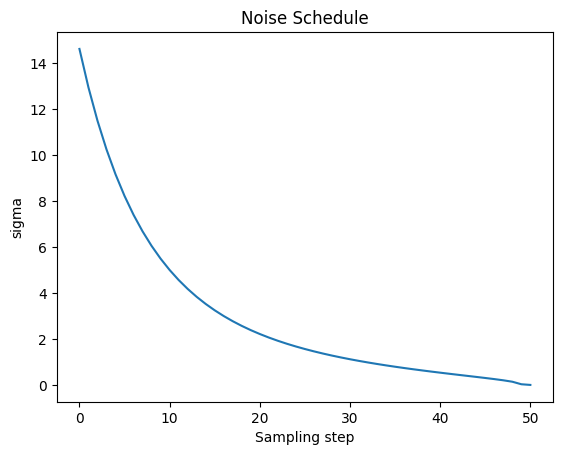

In [98]:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

This 'sigma' is the amount of noise added to the latent representation. Let's see this in action.

### Noising and De-noising

Let's first add noise to our mango cheesecake image. To do this, we create a tensor the same shape as our image, and add a level of noise corresponding to the step 25. Feel free to play around with this, to see how different step levels result in different levels of noise.

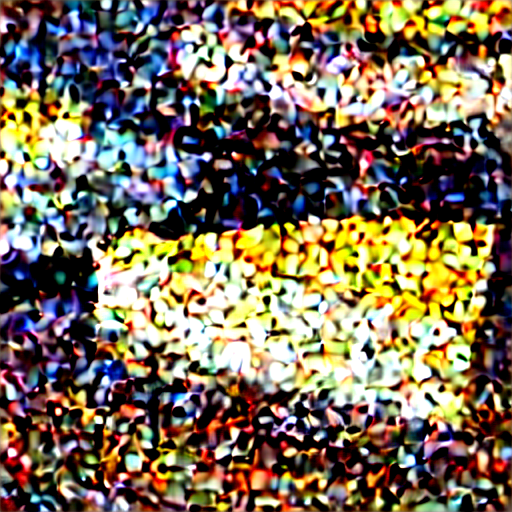

In [18]:
noise = torch.randn_like(mango_cheesecake_latent)
sampling_step = 25
mango_cheesecake_latent_noised = scheduler.add_noise(
    mango_cheesecake_latent, 
    noise, 
    timesteps=torch.tensor([scheduler.timesteps[sampling_step]])
)
latents_to_pil(mango_cheesecake_latent_noised.float())

The `add_noise` function literally takes latents and adds (scaled) noise to those latents. See for yourself by running the code below. 

The important line in the function is `noisy_samples = original_samples + noise * sigma`. This is an element-wise operation that simply adds noise, scaled by the sigma, to each value of the latent tensor.

In the image above, you can still see the outline of the triangular cake shape if you look closely. **You will soon see how our model honors this structure without being explicitly told to do so!**

In [ ]:
??scheduler.add_noise

Now it's time for the main course.

## Dish2Dish: From mango cheesecake to mango tiramisu

Recall that our `stable_diffusion` function creates fresh latents (pure noise) to generate an image from scratch.

But let's see if we can instead feed the model a noised version of our mango cheesecake image. Then, let's see if the model can perfom the remaining de-noising steps with a modified prompt ("mango tiramisu"). Essentially, we are using our mango cheesecake as a starting point for the model to iterate further on, in the direction of a mango tiramisu.

Luckily, we set up our `stable_diffusion` function to receive **custom latents**. Scroll up and refer back to the function if you need a refresher.

Let's pass in the `mango_cheesecake_latent_noised` latents to the model along with the starting step of the loop to our Stable Diffusion functon:

  0%|          | 0/50 [00:00<?, ?it/s]

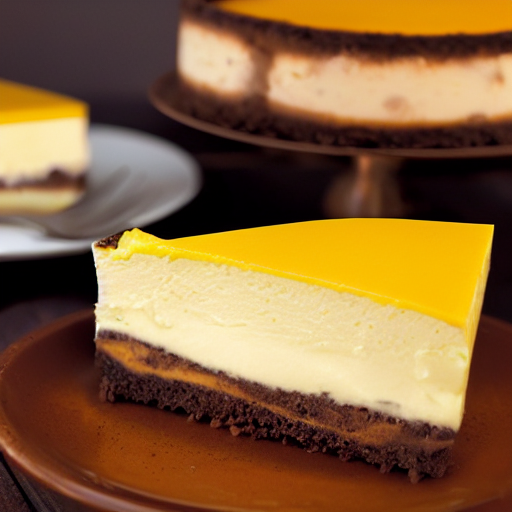

In [20]:
mango_tiramisu = stable_diffusion("A mango tiramisu", custom_latents=mango_cheesecake_latent_noised, loop_start_step=sampling_step)
mango_tiramisu

You can see that the triangular structure of the cheesecake is preserved, along with some of the colors. **However, we still have a new dish**. What we have, is a cross between a mango cheesecake and a mango tirmisu.

If we add more noise to our original mango cheesecake, we perform more de-noising steps. And this means we get further away from the mango cheesecake and closer to a 'purer' mango tiramisu. See for yourself by tweaking the `start_step` variable above.

### Let's try this with a prompt

Can we craft a prompt that explcitly asks for a hybrid between a mango cheesecake & tiramisu without jumping through custom latent hoops? Sure. Let's go back to using our `stable_diffusion` function in its simplest form: Prompt -> Image.

  0%|          | 0/50 [00:00<?, ?it/s]

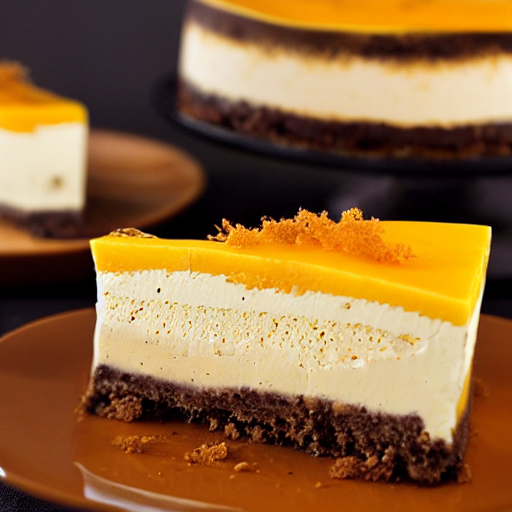

In [108]:
mango_cross = stable_diffusion("A cross between a mango cheesecake and a mango tiramisu")
mango_cross

Whether this is 'better' or 'worse' than our previous hybrid is for you to decide. But the point here is that there are several ways to achieve a desirable outcome if you understand the inner workings of these neural network models. Neither are direct substitues for one another; they are simply different ways of going about your experimentations. 

**This is a confluence of math and art. Much can be created when we understand how these elements work together.**

# Application to the culinary world

We can unlock new possibilities of dishes.

- Chefs and food enthusiasts can explore combinations and presentations of dishes that have not been considered. 
- Restaurants can develop innovative menus and entice their customers with new experiences and flavors.

The culinary world will never be the same.